# Notebook 02: Análisis Estadístico, Correlaciones y Segmentación
En este notebook profundizamos en la relación matemática entre la capacidad económica de los hogares y el coste del alquiler. El objetivo es identificar patrones de comportamiento y localizar zonas donde el mercado inmobiliario se desvía de los fundamentos económicos locales..

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from adjustText import adjust_text

# Cargamos el dataset maestro generado en el Notebook 01
# Usamos utf-8-sig para que los acentos de Segovia salgan perfectos
df = pd.read_csv('../data/cleaned/dataset_maestro_segovia.csv', encoding='utf-8-sig')

sns.set_theme(style="whitegrid")
print(f"Dataset cargado con {len(df)} municipios listos para el análisis.")

Dataset cargado con 24 municipios listos para el análisis.


## 1. Análisis de Correlación de Pearson
Calculamos el coeficiente de Pearson para determinar si existe una relación lineal fuerte entre la **Renta Media** y el **Precio del Alquiler**. 
* Una correlación cercana a **1** indica que a mayor renta, mayor alquiler.
* Una correlación cercana a **0** indicaría que el alquiler se mueve por factores ajenos a la riqueza de los vecinos..

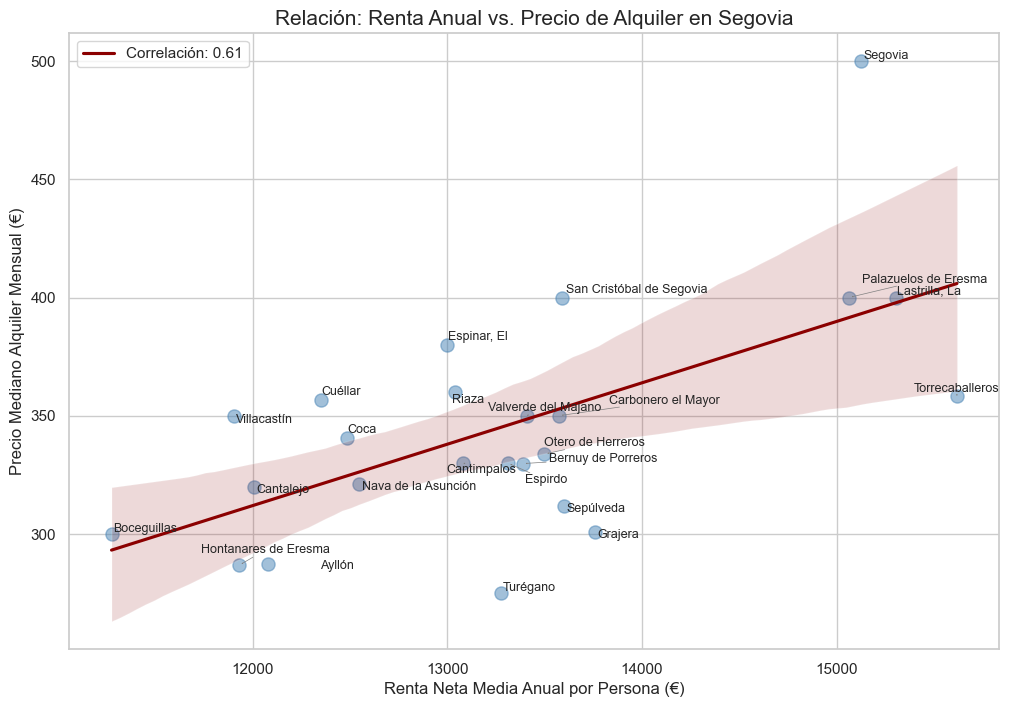

Coeficiente de Correlación: 0.6116
P-valor: 0.0015 (Si es < 0.05, la relación es estadísticamente significativa)


In [2]:
# 1. Calculamos la correlación matemática
corr_val, p_value = pearsonr(df['Total'], df['ALQTBID12_M_VC'])

plt.figure(figsize=(12, 8))

# 2. Dibujamos el gráfico de dispersión con línea de tendencia
sns.regplot(data=df, x='Total', y='ALQTBID12_M_VC', 
            scatter_kws={'s': 90, 'alpha': 0.5, 'color': 'steelblue'}, 
            line_kws={'color': 'darkred', 'label': f'Correlación: {corr_val:.2f}'})

# 3. Ajuste de etiquetas para que no se solapen
texts = []
for i in range(df.shape[0]):
    texts.append(plt.text(df.Total.iloc[i], df.ALQTBID12_M_VC.iloc[i], df.NMUN.iloc[i], fontsize=9))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.title('Relación: Renta Anual vs. Precio de Alquiler en Segovia', fontsize=15)
plt.xlabel('Renta Neta Media Anual por Persona (€)')
plt.ylabel('Precio Mediano Alquiler Mensual (€)')
plt.legend()
plt.show()

print(f"Coeficiente de Correlación: {corr_val:.4f}")
print(f"P-valor: {p_value:.4f} (Si es < 0.05, la relación es estadísticamente significativa)")

## 2. Matriz de Correlación (Heatmap)
Ampliamos el análisis a todas las variables numéricas para observar cómo interactúan el esfuerzo económico y los niveles de renta.

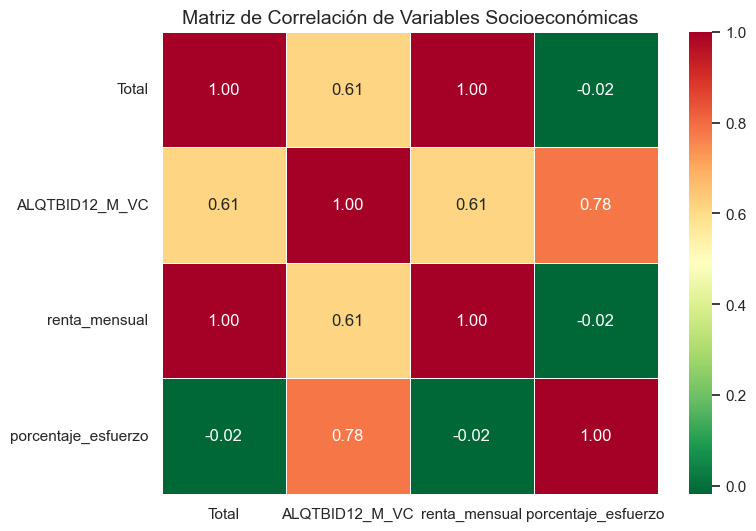

In [4]:
# Seleccionamos variables clave
cols_analisis = ['Total', 'ALQTBID12_M_VC', 'renta_mensual', 'porcentaje_esfuerzo']
matriz_corr = df[cols_analisis].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='RdYlGn_r', fmt=".2f", linewidths=0.5)

plt.title('Matriz de Correlación de Variables Socioeconómicas', fontsize=14)
plt.show()

## 3. Clasificación por Cuadrantes de Mercado
Dividimos la provincia en cuatro segmentos según si su renta y alquiler están por encima o por debajo de la media provincial. Esto nos permite detectar las **Zonas Tensionadas** (Renta baja pero Alquiler alto).

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


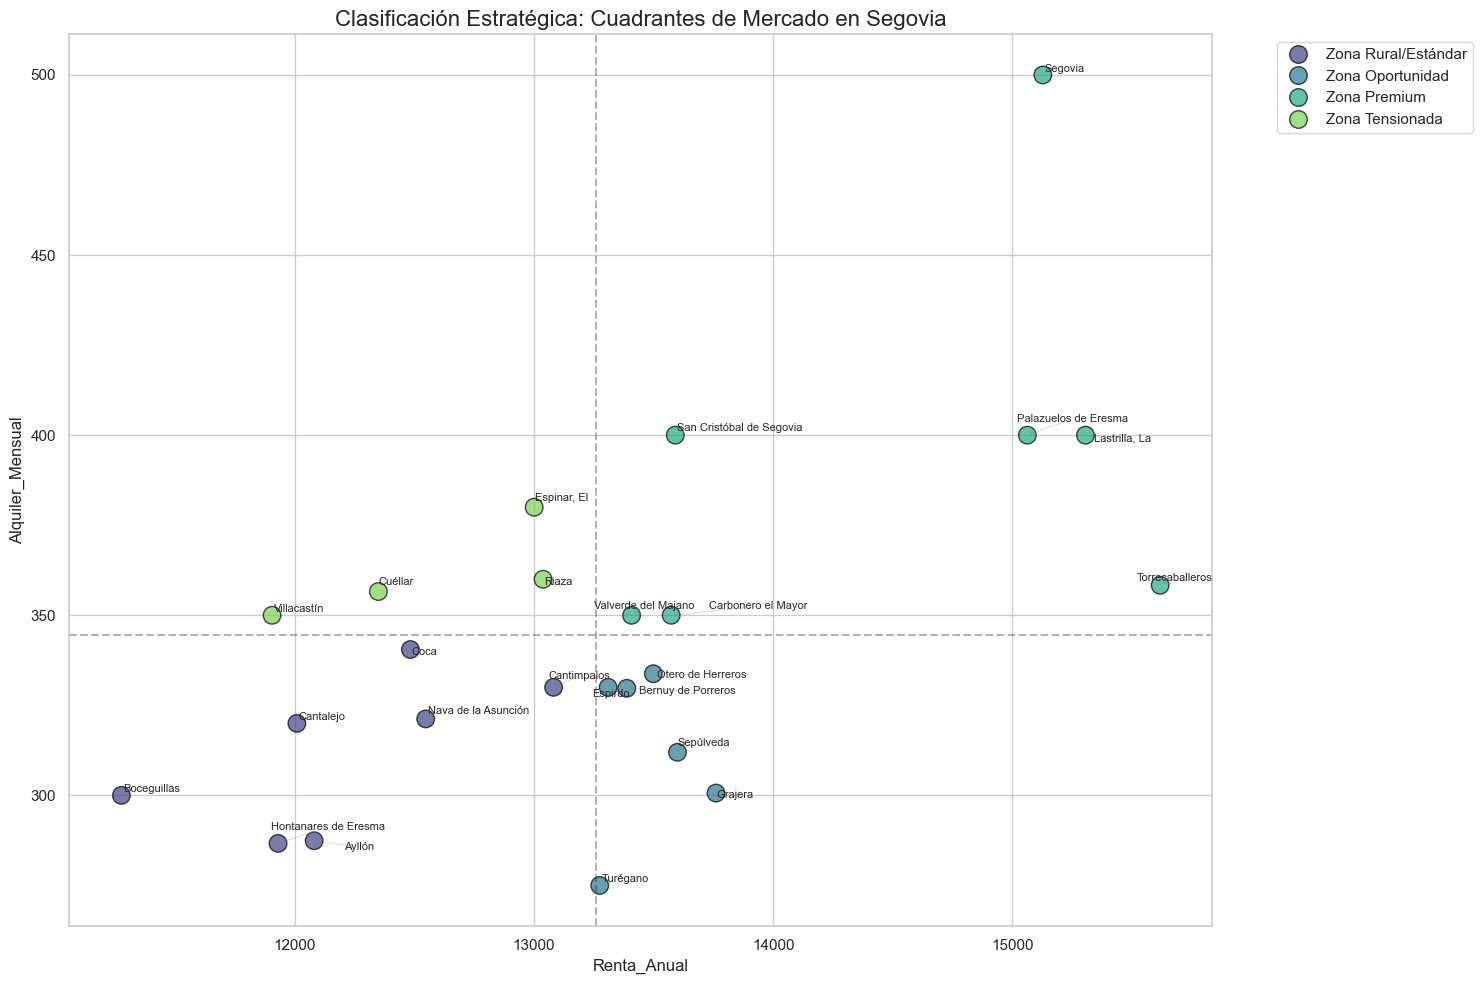

In [6]:
# 1. Preparación de datos y medias
df_plot = df.rename(columns={'Total': 'Renta_Anual', 'ALQTBID12_M_VC': 'Alquiler_Mensual'})
media_renta = df_plot['Renta_Anual'].mean()
media_alq = df_plot['Alquiler_Mensual'].mean()

def segmentar(row):
    if row['Renta_Anual'] > media_renta and row['Alquiler_Mensual'] > media_alq:
        return 'Zona Premium'
    elif row['Renta_Anual'] < media_renta and row['Alquiler_Mensual'] > media_alq:
        return 'Zona Tensionada'
    elif row['Renta_Anual'] > media_renta and row['Alquiler_Mensual'] < media_alq:
        return 'Zona Oportunidad'
    else:
        return 'Zona Rural/Estándar'

df_plot['Segmento'] = df_plot.apply(segmentar, axis=1)

# 2. Visualización
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_plot, x='Renta_Anual', y='Alquiler_Mensual', 
                hue='Segmento', s=160, palette='viridis', edgecolor='black', alpha=0.7)

# 3. Etiquetas de todos los municipios
texts = []
for i in range(df_plot.shape[0]):
    texts.append(plt.text(df_plot.Renta_Anual.iloc[i], df_plot.Alquiler_Mensual.iloc[i], df_plot.NMUN.iloc[i], fontsize=8))

adjust_text(texts, expand_points=(1.7, 1.7), expand_text=(1.2, 1.2),
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, alpha=0.4))

plt.axvline(media_renta, color='black', linestyle='--', alpha=0.3)
plt.axhline(media_alq, color='black', linestyle='--', alpha=0.3)
plt.title('Clasificación Estratégica: Cuadrantes de Mercado en Segovia', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Identificación de Municipios Críticos
Extraemos la lista de municipios que presentan un mercado tensionado para el análisis de conclusiones.to.

In [7]:
# Filtramos la Zona Tensionada
municipios_tensionados = df_plot[df_plot['Segmento'] == 'Zona Tensionada'][['NMUN', 'Renta_Anual', 'Alquiler_Mensual']]
municipios_tensionados['Desviación_vs_Media_Alq'] = municipios_tensionados['Alquiler_Mensual'] - media_alq

print("📋 MUNICIPIOS EN ZONA TENSIONADA (Renta < Media | Alquiler > Media):")
display(municipios_tensionados.sort_values(by='Alquiler_Mensual', ascending=False))

📋 MUNICIPIOS EN ZONA TENSIONADA (Renta < Media | Alquiler > Media):


,NMUN,Renta_Anual,Alquiler_Mensual,Desviación_vs_Media_Alq
8,"Espinar, El",13000.857143,380.000000,35.339971
16,Riaza,13038.000000,360.000000,15.339971
7,Cuéllar,12349.400000,356.591246,11.931217
22,Villacastín,11905.000000,350.000000,5.339971


In [8]:
# Resumen numérico de la segmentación para las conclusiones
resumen_segmentos = df_plot['Segmento'].value_counts()
porcentaje_tensionados = (resumen_segmentos.get('Zona Tensionada', 0) / len(df_plot)) * 100

print(f"📊 Resumen de Mercado:")
print(resumen_segmentos)
print(f"\n💡 El {porcentaje_tensionados:.1f}% de los municipios con datos están en situación de TENSIÓN.")

📊 Resumen de Mercado:
Segmento
Zona Rural/Estándar    7
Zona Premium           7
Zona Oportunidad       6
Zona Tensionada        4
Name: count, dtype: int64

💡 El 16.7% de los municipios con datos están en situación de TENSIÓN.


## 5. Discusión de Resultados y Conclusiones del Bloque 02

Este análisis estadístico nos permite extraer conclusiones sólidas sobre la estructura del mercado inmobiliario en la provincia de Segovia:

### A. Validez del Modelo (Correlación y Regresi* **Correlación Moderada-Fuerte:** El coeficiente de Pearson de **0.61** confirma que existe una relación directa entre riqueza y alquiler, pero no es absoluta. Un 61% de la variación de los precios se explica por la renta, lo que deja un margen relevante a otros factores (presión de los alrededores, escasez de stock o mercado vacacional).
* **Interpretación de la Regresión:** La línea roja marca la tendencia central. Los municipios que se alejan de la **banda de confianza (sombra gris)** son anomalías estadísticas: lugares donde el mercado está "desconectado" de la capacidad adquisitiva real de sus habitantes.blica.

### B. Segmentación del Territorio (Cuadrantes)
La clasificación por cuadrantes nos permite mapear la realidad social:
1. **Zona Premium (Top Derecho):** Núcleos como **Palazuelos de Eresma** o **La Lastrilla**. Son zonas de alta renta y alto alquiler, asociadas al perfil de "municipio dormitorio" de calidad cercano a la capital.
2. **Zona Tensionada (Top Izquierdo):** Es el hallazgo más crítico. Municipios con rentas inferiores a la media pero alquileres superiores. Aquí es donde el **índice de esfuerzo** detectado en el Notebook 01 se vuelve insostenible.
3. **Zona Rural/Estándar (Centro/Bajo):** Representa la estabilidad de la provincia, con precios contenidos y rentas moderadas.

### C. Factores Externos Detectados
A través del **Heatmap**, observamos que el esfuerzo económico no depende solo del precio del alquiler, sino de la velocidad a la que crecen los salarios frente a la vivienda. La persistencia de ciertos municipios en la "Zona Tensionada" sugiere que factores como la **escasez de oferta** o la **proximidad a vías de comunicación con Madrid** están influyendo más que la riqueza de los propsu comportamiento.vo.iva.